In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
import random
import warnings
import multiprocessing as mp
from functools import partial
from scipy.integrate import quad, IntegrationWarning
import time
from datetime import date, time, datetime
from concurrent.futures import ThreadPoolExecutor
import matplotlib


# Import files
from constants import *
from rotation import*
from functions import  d_sigma, d_sigma_sm, sigma_sm, sme, sigma_full, summation_terms, integrate_sigma_hat_prime_sm, integrate_sigma_hat_prime_sme, dsigma_dQ, dsigma_dQ_1,dsigma_dQ_2,dsigma_dQ_3


# matplotlib.rcParms('axes.titlesize') = 12

LHAPDF 6.5.4 loading /home/submit/jbenke/miniforge3/envs/liv-sme/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks


quarks = [
    (2, 2/3*e, 'u', 1/2),
    #  (1, -1/3*e, 'd', -1/2),
     # (3, -1/3*e, 's', -1/2),
     # (4, 2/3*e, 'c', 1/2),
     #  (5, -1/3*e, 'b', -1/2),
     # (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 10)
    g_fR = round(g_fR, 10)
    g_fL = round(g_fL, 10)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2018666667, -0.046673592, 0.453326408)]


In [3]:
quark_couplings1 = [(2, 0.2018666667, -0.046673592, 0.453326408)] ### hard coded for u
quark_couplings2 = [(1, -0.1009333333, 0.023336796, -0.476663204)] ### hard coded for d

In [4]:
print((-6e-6 - 4e-5)*2)

-9.200000000000001e-05


In [5]:
#Don't foregt the metric convenction (+, -, -, -)

cl_1_coeff = 2.5e-4
cl_2_coeff = 2.5e-4
cl_3_coeff = 1e-4
cl_4_coeff = 1e-4

g = tn.tensor([
    [1,0,0,0],
    [0,-1,0,0],
    [0,0,-1,0],
    [0,0,0,-1]
], dtype=tn.float32)
# cl_1_coeff = 1e-2
CL1 = tn.tensor([
    [0, 0, 0, 0],
    [0, cl_1_coeff, 0, 0],
    [0, 0, -cl_1_coeff, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
# cl_2_coeff = 0.85109
CL2 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, -cl_2_coeff, 0],
    [0, -cl_2_coeff, 0, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
# cl_3_coeff = 8e-2
CL3 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, -cl_3_coeff],
    [0, 0, 0, 0],
    [0,-cl_3_coeff, 0, 0]
], dtype=tn.float32)
# cl_4_coeff = 1.22031
CL4 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, -cl_4_coeff],
    [0,0,-cl_4_coeff, 0]
], dtype=tn.float32)



# CL1 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 1e-4, 0, 0],
#     [0, 0, -1e-4, 0],
#     [0,0, 0, 0]
# ], dtype=tn.float32)
# CL2 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, -1e-4, 0],
#     [0, -1e-4, 0, 0],
#     [0,0, 0, 0]
# ], dtype=tn.float32)
# CL3 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, 0, -1e-4],
#     [0, 0, 0, 0],
#     [0,-1e-4, 0, 0]
# ], dtype=tn.float32)
# CL4 = tn.tensor([
#     [0, 0, 0, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, -1e-4],
#     [0,0,-1e-4, 0]
# ], dtype=tn.float32)



CLzz = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0,0,0, -1e-4]
], dtype=tn.float32)


CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

## Rotation matrcies from the SCF ro CMS frame as a function of siderieal time

In [6]:
# Define the constant tensors once
p1 =  0.5*tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 =  0.5*tn.tensor([1, 0, 0, -1], dtype=tn.float32)

# Precompute total number of steps

specific_time = datetime(2017, 1, 1, 0, 0)

start_time = int(specific_time.timestamp())

# start_time = int(time.time())
end_time = start_time + int(timedelta(days=1).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contrelep1 = []
contrelep2 = []

R_y_lat = R_y(latitude)
R_z_azi = R_z(azimuth)
mat_cons = tn.matmul(R_y_lat,R_z_azi)
# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830 
    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    R_mat = tn.matmul(R_Z_omega, mat_cons)
    R_matrix1 = tn.einsum('ma,an->mn', g, R_mat)
    R_matrix2 = tn.einsum('am,na->mn', g, R_mat)
    # print(R_matrix1)
    # Compute contrL and contrR using matrix multiplication
    contrp1 = tn.einsum('ij,j->i', R_matrix1, p1)
    contrp2 =  tn.einsum('ij,i->j',R_matrix2, p2)
    # Record the times and contr matrix elements
    times.append(current_time)
    contrelep1.append(contrp1)
    contrelep2.append(contrp2)


    # Move to the next time step
    current_time += step_seconds

#  Drell-Yan cross section in the presence of LIV contribution
\begin{align*}
    &\frac{d\sigma}{dQ^2} = \frac{4\pi \alpha_{EM}^2}{3N_c} \sum_f \Bigg[\frac{e_f^2}{2Q^4}+\frac{1-M_Z^2/Q^2}{(Q^2-M_Z^2)^2+M_Z^2\Gamma_Z^2}\frac{1-4\sin^2{\theta_w}}{32\sin^2{\theta_w}\cos^2{\theta_w}}e_fg_{fL}\\ 
    &+\frac{1}{(Q^2-M_Z^2)^2+M_Z^2\Gamma_z^2}\frac{1+(1-4\sin{\theta_w})^2}{32\sin^4{\theta_w}\cos^4{\theta_w}}g_{fL}^2 \Bigg]\int^1_\tau dx \; \frac{\tau}{x}\; \frac{\hat{\sigma}_f}{dQ^2}(x, \tau/x, c^{\mu \nu}_{fL})+(L\rightarrow R)
\end{align*}

In [7]:
%%time

warnings.simplefilter("ignore", IntegrationWarning)

def compute_result(args, sigma_sm_value):
    pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CR = args
    Q_min = 70
    Q_max = 80  
    
    coeff_list = [CL1, CL2, CL3, CL4] 
    coupling_dict = {}

    result_sme1 = sme(Q_min, Q_max, CL1, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme2 = sme(Q_min, Q_max, CL2, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme3 = sme(Q_min, Q_max, CL3, CR, pm, pn, quark_couplings, sigma_sm_value)
    result_sme4 = sme(Q_min, Q_max, CL4, CR, pm, pn, quark_couplings, sigma_sm_value)

    # Add the SM result to each of the SME results after the loop
    final_result_sme1 = result_sme1 + sigma_sm_value
    final_result_sme2 = result_sme2 + sigma_sm_value
    final_result_sme3 = result_sme3 + sigma_sm_value
    final_result_sme4 = result_sme4 + sigma_sm_value
    
    # Return the result as a dictionary
    return {
        'result_sme1': final_result_sme1,
        'result_sme2': final_result_sme2,
        'result_sme3': final_result_sme3,
        'result_sme4': final_result_sme4
    }

# Calculate sigma_sm once outside the loop since it doesn't depend on p1, p2, or CL.
Q_min = 70
Q_max = 80
sigma_sm_value = sigma_sm(Q_min, Q_max, quark_couplings)

# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result = partial(compute_result, sigma_sm_value=sigma_sm_value)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results = pool.map(partial_compute_result, args_list)

# Function to convert timestamps to hours
def convto_hours(timestamps):
    start_time = timestamps[0]  # The start time to normalize
    return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# Perform conversion
hours_start = convto_hours(times)

CPU times: user 17.3 s, sys: 2.11 s, total: 19.4 s
Wall time: 33.1 s


In [8]:
### i changed this

dratios = [np.array([result[f'result_sme{i+1}'] / sigma_sm_value for result in results]) for i in range(4)]

hours_array = np.array(hours_start)
if cl_1_coeff == cl_2_coeff == cl_3_coeff == cl_4_coeff == 1:
    dratios_REAL = [np.array([result[f'result_sme{i+1}'] / sigma_sm_value for result in results]) for i in range(4)]
    print("everything is one")
    for k in range(len(dratios)):
        dratios_lim=[float(i) for i in dratios_REAL[k]]
        hours_array = np.array(hours_start)
        out_array = np.column_stack((hours_array, dratios_lim))
        np.save(f"coupling_models/coupling_before_{k+1}", out_array)
        
# DRATIOS_CLEAN = 

In [31]:
amplitudes_in = np.load("/work/submit/jbenke/WRemnants/scripts/corrections/liv_fit_final_amplitudes.npy")
### goign to choose mass bin 5 because that is in the middle

mass_bin = 5
cxx_lu = amplitudes_in[mass_bin, 0, 0] * 2.74959
cxy_lu = amplitudes_in[mass_bin, 1, 0] * 2.51003
cxz_lu = amplitudes_in[mass_bin, 2, 0] * 1.16266
cyz_lu = amplitudes_in[mass_bin, 3, 0] * 1.15223 

cxx_lu_unc = cxx_lu * 244.88802
cxy_lu_unc = cxy_lu * 248.00408
cxz_lu_unc = cxz_lu  * 114.81197
cyz_lu_unc = cyz_lu * 113.7401



## down quark
cxx_ld = amplitudes_in[mass_bin, 0, 1] * 4.300365
cxy_ld = amplitudes_in[mass_bin, 1, 1] * 4.3572
cxz_ld = amplitudes_in[mass_bin, 2, 1] * 2.1092
cyz_ld = amplitudes_in[mass_bin, 3, 1] * 1.99839

cxx_ld_unc = cxx_ld  * 424.69915
cxy_ld_unc = cxy_ld * 430.51034
cxz_ld_unc = cxz_ld * 199.3943
cyz_ld_unc = cyz_ld * 197.26

print("up quark")
print(f'cxx_u = {cxx_lu} +- {cxx_lu_unc}')
print(f'cxy_u = {cxy_lu} +- {cxy_lu_unc}')
print(f'cxz_u = {cxz_lu} +- {cxz_lu_unc}')
print(f'cyz_u = {cyz_lu} +- {cyz_lu_unc}')

print("down quark")
print(f'cxx_d = {cxx_ld} +- {cxx_ld_unc}')
print(f'cxy_d = {cxy_ld} +- {cxy_ld_unc}')
print(f'cxz_d = {cxz_ld} +- {cxz_ld_unc}')
print(f'cyz_d = {cyz_ld} +- {cyz_ld_unc}')

# print("--------")
# ##### SUS - SAYS THESE ARE BETTER CONSTRAINTS
# input_scale = (max(dratios_REAL[0]) - 1)*0.13284 
# print(input_scale)
# input_scale = (max(dratios_REAL[1]) - 1)*0.13326 
# print(input_scale)
# input_scale = (max(dratios_REAL[2]) - 1)*0.06361 
# print(input_scale)
# input_scale = (max(dratios_REAL[3]) - 1)*0.06343
# print(input_scale)

### making differences in the 4th decimal point, not of an ordre of magnitude (womp). 

up quark
cxx_u = 0.04485625266626868 +- 10.984758900062259
cxy_u = 0.04089807088086972 +- 10.142888442584884
cxz_u = 0.039656889451311246 +- 4.553085601977263
cyz_u = 0.03930135620013647 +- 4.470140184339142
down quark
cxx_d = 0.03894569053880972 +- 16.54020166799553
cxy_d = 0.03946023367966354 +- 16.9880386179114
cxz_d = 0.03998632905144536 +- 7.973046090782612
cyz_d = 0.03788583809027076 +- 7.47336042168681


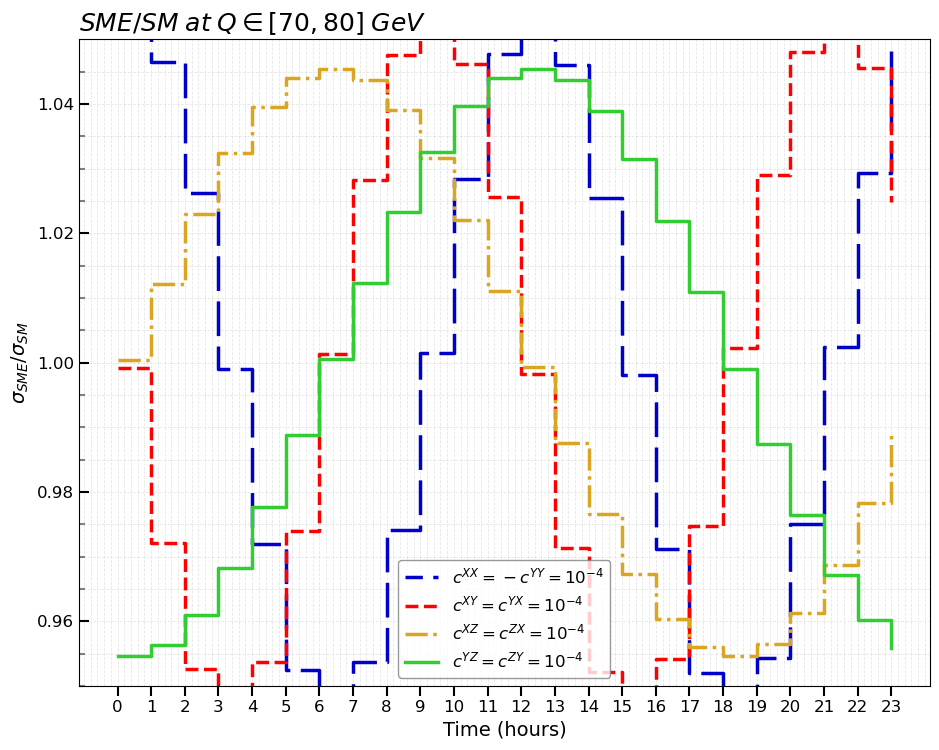

In [10]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
colors = ['mediumblue', 'red', 'goldenrod','limegreen' ]
# Increase line width and adjust line styles for differentiation
line_styles = [(5, (10, 3)), '--', '-.', '-']

c1_label = "{:e}".format(1e-4*cl_1_coeff, 3)
c2_label = "{:e}".format(1e-4*cl_2_coeff, 3)
c3_label = "{:e}".format(1e-4*cl_3_coeff, 3)
c4_label = "{:e}".format(1e-4*cl_4_coeff, 3)

labels=['$c^{XX}=-c^{YY}=10^{-4}$','$c^{XY}=c^{YX}=10^{-4}$', '$c^{XZ}=c^{ZX}=10^{-4}$','$c^{YZ}=c^{ZY}=10^{-4}$']

# labels=['$c^{11}=-c^{22}=$' + f'{c1_label}','$c^{12}=c^{21}=$'+ f'{c2_label}', '$c^{13}=c^{31}=$'+f'{c3_label}','$c^{23}=c^{32}=$' +f'{c4_label}']

for i in range(4):
    plt.step(hours_array, dratios[i], where='post', color=colors[i], label=labels[i], linewidth=2.5, linestyle=line_styles[i])

# Customizing the legend: move it inside the plot area, adjust font size, and add a background
plt.legend(loc='best', fontsize=12, frameon=True, fancybox=True, framealpha=0.8, edgecolor='gray')

# Adding labels and title with increased font size for clarity
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel(r'$\sigma_{SME}/\sigma_{SM}$', fontsize=14)
plt.title(r'$SME/SM \; at \; Q \in [70,80] \; GeV$', fontsize=18, loc='left')

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.3)

# Adjust tick parameters for better readability
plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)  
plt.tick_params(which='both', width=1.5)
plt.tick_params(which='major', length=7, labelsize=12)
plt.tick_params(which='minor', length=4, color='gray')
plt.tick_params(axis='y', direction='in', which='both', labelsize=12) 
# plt.ylim([0.992, 1.008])
plt.ylim([0.95, 1.05])

# Customize x-ticks
plt.xticks(ticks=range(0, 24, 1), labels=[str(hour) for hour in range(0, 24, 1)])

# Adjust layout to prevent clipping of labels and title
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

# Save and show the plot
plt.savefig("/home/submit/jbenke/public_html/liv_coeff.png", bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()



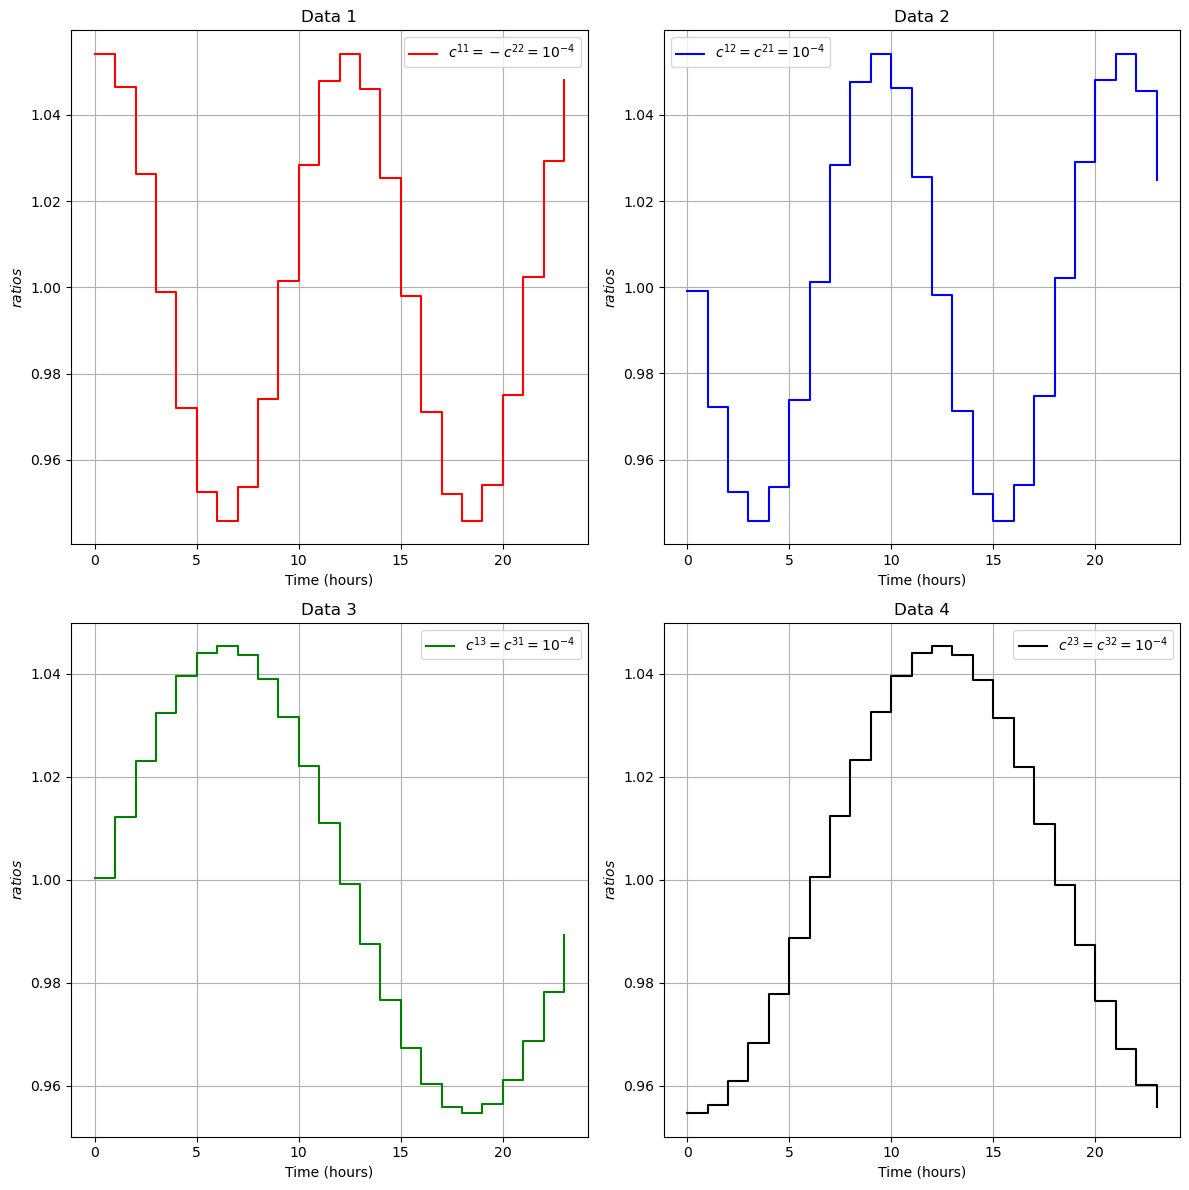

In [11]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot data in each subplot
axs[0, 0].step(hours_array, dratios[0], where='post', color='r', label='$c^{11}=-c^{22}=10^{-4}$')
axs[0, 0].set_title('Data 1')
axs[0, 0].set_xlabel('Time (hours)')
axs[0, 0].set_ylabel('$ratios$')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].step(hours_array, dratios[1], where='post', color='b', label='$c^{12}=c^{21}=10^{-4}$')
axs[0, 1].set_title('Data 2')
axs[0, 1].set_xlabel('Time (hours)')
axs[0, 1].set_ylabel('$ratios$')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].step(hours_array, dratios[2], where='post', color='g', label='$c^{13}=c^{31}=10^{-4}$')
axs[1, 0].set_title('Data 3')
axs[1, 0].set_xlabel('Time (hours)')
axs[1, 0].set_ylabel('$ratios$')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].step(hours_array, dratios[3], where='post', color='black', label='$c^{23}=c^{32}=10^{-4}$')
axs[1, 1].set_title('Data 4')
axs[1, 1].set_xlabel('Time (hours)')
axs[1, 1].set_ylabel('$ratios$')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_sme_for_bin(Q_range):
    # Unpack the tuple
    Q_start, Q_end = Q_range
    # Function to compute SME for a given range
    return sme(Q_start, Q_end, CLzz, CLzz, p1, p2, quark_couplings1)

if __name__ == '__main__':
    Q_val = np.linspace(17.5, 90, 100)
    a = 17.5  # Start of the Q range
    b = 90  # End of the Q range
    nbins = 17  # Number of bins

    # Q_bins = np.linspace(a, b, nbins + 1)
    # Q_bins = np.linspace(60, 120, 10)
    Q_bins = np.array([50, 60.3, 85.2298, 88.1398, 89.3644, 90.16, 90.8102, 91.428, 92.1163, 93.0461, 94.9463, 120, 130])

    # Prepare the list of arguments for each bin
    bin_ranges = [(Q_bins[i], Q_bins[i + 1]) for i in range(len(Q_bins) - 1)]

    # Use multiprocessing to compute SME values
    with mp.Pool() as pool:
        sme_values1 = pool.map(compute_sme_for_bin, bin_ranges)

CPU times: user 257 ms, sys: 2.51 s, total: 2.77 s
Wall time: 39.6 s


In [13]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_sme_for_bin(Q_range):
    # Unpack the tuple
    Q_start, Q_end = Q_range
    # Function to compute SME for a given range
    return sme(Q_start, Q_end, CLzz, CLzz, p1, p2, quark_couplings2)

if __name__ == '__main__':
    Q_val = np.linspace(17.5, 90, 100)
    a = 17.5  # Start of the Q range
    b = 90  # End of the Q range
    nbins = 17  # Number of bins

    Q_bins = np.array([50, 60.3, 85.2298, 88.1398, 89.3644, 90.16, 90.8102, 91.428, 92.1163, 93.0461, 94.9463, 120, 130])
    # Q_bins = np.linspace(60, 120, 10)

    # Prepare the list of arguments for each bin
    bin_ranges = [(Q_bins[i], Q_bins[i + 1]) for i in range(len(Q_bins) - 1)]

    # Use multiprocessing to compute SME values
    with mp.Pool() as pool:
        sme_values2 = pool.map(compute_sme_for_bin, bin_ranges)


CPU times: user 247 ms, sys: 2.49 s, total: 2.73 s
Wall time: 39.5 s


In [14]:
print(sme_values2[-1])

0.020068218968419146


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


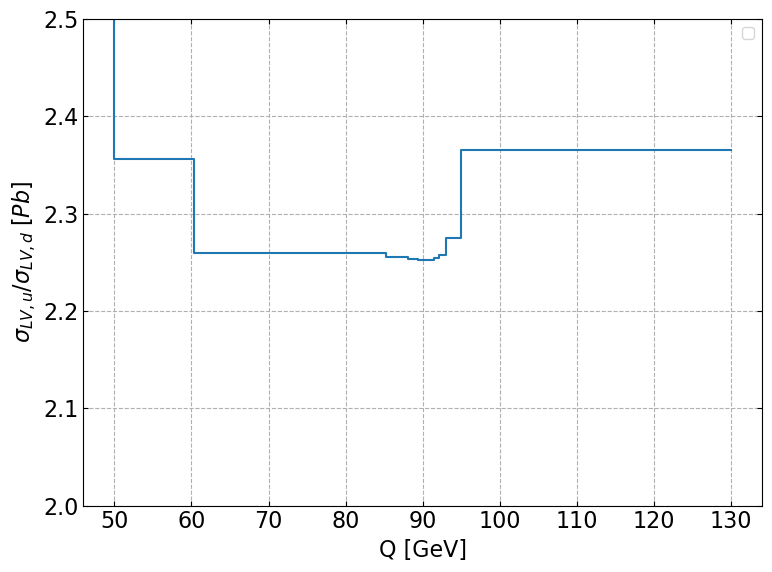

In [27]:
plt.figure(figsize=(8, 6))
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

# Create the step plot
# plt.step(Q_bins,  sme_values1 + [sme_values1[-1]], where='post', color='firebrick', linestyle='--', label = '$c^{33}_{u}=10^{-4}$')
# plt.step(Q_bins,  sme_values2 + [sme_values2[-1]], where='post', color='blue', label = '$c^{33}_{d}=10^{-4}$')
up = np.array(sme_values1 + [sme_values1[-1]])
down = np.array(sme_values2 + [sme_values2[-1]])
plt.step(Q_bins, up/down)

plt.xlabel('Q [GeV]')
# plt.yscale('log')
plt.ylim([2, 2.5])
plt.ylabel('$\\sigma_{LV, u}/\\sigma_{LV, d} \\;[Pb]$')
# plt.title('Lorentz violation contribution in the cross section')
plt.grid(True, which="both", ls="--")  

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)


plt.tight_layout()
plt.legend(fontsize=11, loc='best')
# Save and show the plot
plt.savefig('intrsec.png', dpi=300)
plt.show()



In [17]:
mass_dependency =  sme_values1 + [sme_values1[-1]]
# mass_dependency =  sme_values2 + [sme_values2[-1]]

np.save("coupling_models/mass_dependence_up", mass_dependency)
print(len(mass_dependency))

13


## SM predictions for the Drell-Yan process

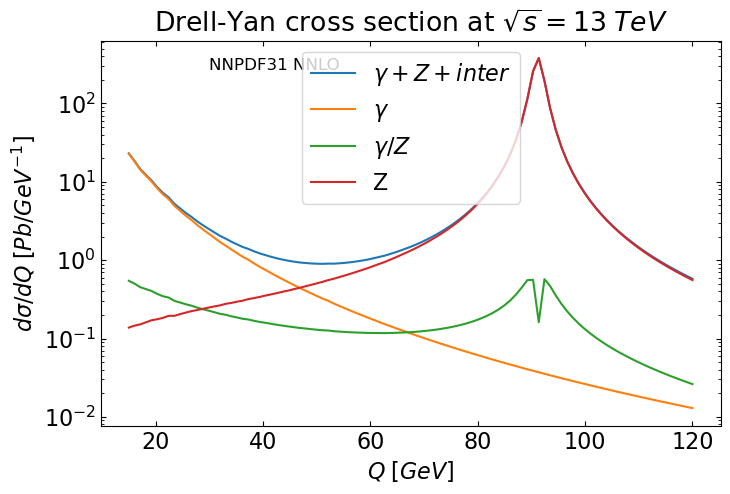

In [83]:
Q_val = np.linspace(15, 120, 100)
all = [dsigma_dQ(Q**2, quark_couplings) for Q in Q_val]
gamma = [dsigma_dQ_1(Q**2, quark_couplings) for Q in Q_val]
gammaZ = [dsigma_dQ_2(Q**2, quark_couplings) for Q in Q_val]
Z = [dsigma_dQ_3(Q**2, quark_couplings) for Q in Q_val]

plt.figure(figsize=(8, 5))

# Plot all datasets with labels for the legend
plt.plot(Q_val, all, label='$\\gamma+Z+inter$')
plt.plot(Q_val, gamma, label='$\\gamma$')
plt.plot(Q_val, gammaZ, label='$\\gamma/Z$')
plt.plot(Q_val, Z, label='Z')

# Set the labels
plt.xlabel('$Q\;[GeV]$')
plt.yscale('log')
plt.ylabel('$d\\sigma/dQ \\;[Pb/GeV^{-1}]$')
plt.title('Drell-Yan cross section at $\\sqrt{s}= 13\;TeV$')

# Enable ticks on all four borders
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)

# Add text inside the plot
plt.text(30, max(all) * 0.7, 'NNPDF31 NNLO', fontsize=12, color='black')

# Show legend
plt.legend()

# Save the figure
plt.savefig('drellyan.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [18]:
input_scale = (max(dratios[2]) - 1)*1.9528045214744079*1e3*0.00347
print(input_scale)

0.2479291520904545


In [19]:
from scipy.optimize import root_scalar

# Step 1: define wrapper to compute SME cross section ratio
def sme_ratio(CL_tensor, quark_couplings, Qmin, Qmax, p1, p2, sigma_sm_value):
    sme_val = sme(Qmin, Qmax, CL_tensor, CR, p1, p2, quark_couplings, sigma_sm_value)
    return (sme_val + sigma_sm_value) / sigma_sm_value

# Step 2: build a function of a scalar coefficient multiplier
def ratio_from_CL_scalar(CL_base_tensor, scalar, **kwargs):
    CL_scaled = scalar * CL_base_tensor
    return sme_ratio(CL_scaled, **kwargs)

# Step 3: root-finder to solve ratio(scalar) = target_ratio
def solve_for_CL_scalar(CL_base_tensor, target_ratio, scalar_bounds, **kwargs):
    def func(scalar):
        return ratio_from_CL_scalar(CL_base_tensor, scalar, **kwargs) - target_ratio
    
    sol = root_scalar(func, bracket=scalar_bounds, method='brentq')
    if not sol.converged:
        raise RuntimeError("Root-finding failed to converge.")
    return sol.root

In [20]:
from scipy.optimize import root_scalar

# Step 1: define wrapper to compute SME cross section ratio
def sme_ratio(CL_tensor, quark_couplings, Qmin, Qmax, p1, p2, sigma_sm_value):
    sme_val = sme(Qmin, Qmax, CL_tensor, CR, p1, p2, quark_couplings, sigma_sm_value)
    return (sme_val + sigma_sm_value) / sigma_sm_value

# Step 2: build a function of a scalar coefficient multiplier
def ratio_from_CL_scalar(CL_base_tensor, scalar, **kwargs):
    CL_scaled = scalar * CL_base_tensor
    return sme_ratio(CL_scaled, **kwargs)

# Step 3: root-finder to solve ratio(scalar) = target_ratio
def solve_for_CL_scalar(CL_base_tensor, target_ratio, scalar_bounds, **kwargs):
    def func(scalar):
        return ratio_from_CL_scalar(CL_base_tensor, scalar, **kwargs) - target_ratio
    
    sol = root_scalar(func, bracket=scalar_bounds, method='brentq')
    if not sol.converged:
        raise RuntimeError("Root-finding failed to converge.")
    return sol.root



target_ratio =1 + (max(dratios[2]) - 1)*1.9528045214744079*1e3*0.00347# 2% increase
print(target_ratio)
Qmin, Qmax = 70, 80
sigma_sm_val = sigma_sm(Qmin, Qmax, quark_couplings)

params = dict(
    quark_couplings=quark_couplings,
    Qmin=Qmin,
    Qmax=Qmax,
    p1=p1,
    p2=p2,
    sigma_sm_value=sigma_sm_val,
)

# Solve for CL1
scalar_solution = solve_for_CL_scalar(CL3, target_ratio, scalar_bounds=(-1e-7, 1e-3), **params)
print(f"Required scalar for CL1 to get ratio {target_ratio}: {scalar_solution:.2e}")

# Use the tensor in your simulation
CL3_target = scalar_solution * CL3

1.2479291520904545


ValueError: f(a) and f(b) must have different signs